# HW2 - DENSER-Like Algorithms

## Import Libraries

In [29]:
from IPython.display import display, HTML
import cv2
import os
import random
import warnings 
import numpy as np
import pandas as pd
import seaborn
import torch.nn as nn
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from keras.layers import BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import datasets, Sequential, layers, models, initializers, regularizers, optimizers, metrics, utils
from tensorflow.keras import models
from keras_tuner import RandomSearch
from tensorflow.keras.utils import load_img, img_to_array
from PIL import ImageFile
import tensorflow.keras.utils  as utils
from IPython.display import display
import pydot
from sklearn.model_selection import train_test_split

C:\Users\rfdns\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Reshape the data to include the channel dimension
train_images = train_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))

# Split the original training data to create a validation set
x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# The resulting shape of data
print("Training set: ", x_train.shape)
print("Validation set: ", x_val.shape)
print("Test set: ", test_images.shape)


Training set:  (48000, 28, 28, 1)
Validation set:  (12000, 28, 28, 1)
Test set:  (10000, 28, 28, 1)


Epoch 1/5
1500/1500 [==============================] - 10s 6ms/step - loss: 0.1908 - accuracy: 0.9451 - val_loss: 0.0931 - val_accuracy: 0.9746
Epoch 2/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0714 - accuracy: 0.9785 - val_loss: 0.0777 - val_accuracy: 0.9761
Epoch 3/5
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0505 - accuracy: 0.9845 - val_loss: 0.0727 - val_accuracy: 0.9782
Epoch 4/5
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0379 - accuracy: 0.9884 - val_loss: 0.0769 - val_accuracy: 0.9768
Epoch 5/5
313/313 [==============================] - 1s 1ms/step - loss: 0.0713 - accuracy: 0.9777


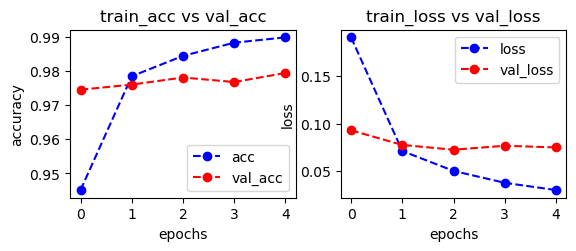

In [31]:
#Defining a string-based representation for the networks (the genotype)
model = models.Sequential()
inputlayer = model.add(layers.Input(shape=(28,28,1))) 
outputlayer =  model.add(layers.Dense(10, activation="softmax", kernel_initializer=initializers.GlorotNormal(seed=999)))

def base_cnn(act_1, n_filt_1, act_2='softmax', kernel_size=(3,3), model_name='Model', seed=999):
  model = models.Sequential(name=model_name)
  model.add(layers.Input(shape=(28,28,1))) 
  model.add(layers.Conv2D(n_filt_1, kernel_size, activation=act_1, kernel_initializer=initializers.GlorotNormal(seed=seed)))
  model.add(layers.Flatten())
  model.add(layers.Dense(10, activation=act_2, kernel_initializer=initializers.GlorotNormal(seed=seed)))
  return model

model = base_cnn(act_1='relu', n_filt_1=32, model_name='MNIST_Model')

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

model.evaluate(test_images, test_labels)

# Plot accuracy 
plt.subplot(221)
plt.plot(history.history['accuracy'], 'bo--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'ro--', label = 'val_acc')
plt.title('train_acc vs val_acc')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

# Plot loss function
plt.subplot(222)
plt.plot(history.history['loss'], 'bo--', label = 'loss')
plt.plot(history.history['val_loss'], 'ro--', label = 'val_loss')
plt.title('train_loss vs val_loss')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.show()

## Definition of the string-based genome

In [32]:
#Defining a string-based representation for the networks (the genotype)
inputlayer = model.add(layers.Input(shape=(28,28,1))) 
outputlayer =  model.add(layers.Dense(10, activation="softmax", kernel_initializer=initializers.GlorotNormal(seed=999)))

## Defining a network class that is able to parse those instructions and build a functional pytorch network structure (the phenotype).

In [33]:
#Each network needs to have at least 1 layer and a maximum 50 layers. This choice
#needs to be made at random when generating the genotype.


class DeepNetwork:
    def __init__(self, genotype, phenotype):
        self.genotype
        self.phenotype
    
    def set_genotype(self, genotype_value):
        self.genotype = genotype_value

    def set_phenotype(self, phenotype_value):
        self.phenotype = phenotype_value

    def genotype_to_phenotype(genotype):
        #Tenho de construir aqui o transformador de g para f        
        self.genotype = genotype_value
        return genotype
    
    
import random

# Define a list of tuples, where each tuple contains the layer/activation function name and parameter ranges
layers_and_activations = [
    ('Linear', [('number_of_features', 1, 512), ('bias', 0.0, 1.0)]),
    ('BatchNorm1d', [('eps', 1e-5, 1e-2), ('momentum', 0.1, 0.99)]),
    ('LayerNorm', [('eps', 1e-5, 1e-2)]),
    ('Dropout', [('dropout_probability', 0.0, 1.0)]),
    ('AlphaDropout', [('dropout_probability', 0.0, 1.0)]),
    ('Activation', ['Sigmoid', 'ReLU', 'PReLU', 'ELU', 'SELU', 'GELU', 'CELU', 'SiLU']),
]

def select_random_params(layer_tuple):
    """
    Selects random parameters within the provided range for a given layer.
    """
    layer_name, param_list = layer_tuple
    random_params = []

    # For 'Activation', we just want to randomly select one from the list
    if layer_name == 'Activation':
        random_params.append(('function', random.choice(param_list)))
    else:
        for param_tuple in param_list:
            if isinstance(param_tuple[1], int):  # integer parameter
                random_value = random.randint(param_tuple[1], param_tuple[2])
            else:  # float parameter
                random_value = random.uniform(param_tuple[1], param_tuple[2])
                random_value = round(random_value, 6)  # rounding to keep the number manageable

            random_params.append((param_tuple[0], random_value))

    return layer_name, random_params

# Test the function with each layer
for layer in layers_and_activations:
    print(f"{select_random_params(layer)}")


('Linear', [('number_of_features', 194), ('bias', 0.201372)])
('BatchNorm1d', [('eps', 0.009792), ('momentum', 0.676263)])
('LayerNorm', [('eps', 0.003351)])
('Dropout', [('dropout_probability', 0.315795)])
('AlphaDropout', [('dropout_probability', 0.301314)])
('Activation', [('function', 'CELU')])


## Defining a string-based representation for the optimizer.

In [34]:
#Defining a string-based representation for the networks (the genotype)
optimizers = [
    ('Adam', [('lr', -3, 0), ('beta1', 0.8, 0.9), ('beta2', 0.99, 0.999)]),
    ('AdamW', [('lr', -4, -1), ('beta1', 0.8, 0.9), ('beta2', 0.99, 0.999), ('weight_decay', -4, -1)]),
    ('Adadelta', [('lr', -3, 0), ('rho', 0.9, 0.99)]),
    ('NAdam', [('lr', -3, 0), ('beta1', 0.8, 0.9), ('beta2', 0.99, 0.999), ('momentum_decay', 0.003, 0.005)]),
    ('SGD', [('lr', -3, 0), ('momentum', 0.5, 0.99), ('nesterov', False, True)]),
]

def select_random_params(optimizer_tuple):
    """
    Selects random parameters within the provided range for a given optimizer.
    """
    optimizer_name, param_list = optimizer_tuple
    random_params = []

    for param_tuple in param_list:
        if param_tuple[0] == 'nesterov':  # boolean parameter
            random_value = random.choice([param_tuple[1], param_tuple[2]])
        else:  # float parameter
            random_value = 10 ** random.uniform(param_tuple[1], param_tuple[2])
            random_value = round(random_value, 6)  # rounding to keep the number manageable

        random_params.append((param_tuple[0], random_value))

    return optimizer_name, random_params

# Test the function with each optimizer
for optimizer in optimizers:
    print(f"{select_random_params(optimizer)}")
    

('Adam', [('lr', 0.057188), ('beta1', 7.823246), ('beta2', 9.888075)])
('AdamW', [('lr', 0.063254), ('beta1', 6.546013), ('beta2', 9.881265), ('weight_decay', 0.004354)])
('Adadelta', [('lr', 0.683292), ('rho', 7.983537)])
('NAdam', [('lr', 0.467142), ('beta1', 6.749476), ('beta2', 9.863226), ('momentum_decay', 1.00972)])
('SGD', [('lr', 0.010696), ('momentum', 3.329934), ('nesterov', False)])


## Defining a way to parse those instructions and build and functional pytorch optimizer.

In [35]:
class DeepOptimizers:
    def __init__(self, genotype=None, phenotype=None):
        if genotype is None:
            self.genotype = genotype
            self.phenotype = phenotype
        else:
            self.genotype = genotype
            self.phenotype = phenotype
    
    def set_genotype(self, genotype_value):
        self.genotype = genotype_value

    def set_phenotype(self, phenotype_value):
        self.phenotype = phenotype_value

    def genotype_to_phenotype(genotype):
        #Tenho de construir aqui o transformador de g para f        
        self.genotype = genotype_value
        return genotype

## Sample all parameter values from a grammar (this allows for a restricted search space and removes the need to deal with invalid combinations).

### Rules
1. BatchNorm vs LayerNorm
2. Dropout vs AlphaDropout
3. Dropout or Norm after Linear

## Define 4 simple genetic operators:
1. Network crossover
2. Add layer mutation
3. Remove layer mutation
4. Change optimizer mutation

## Experimental setup

In [36]:
def initialize_population(genotype=None):
    return ([DeepNetwork(genotype=genotype) for _ in range(5)])

def run(self, selection=0, crossover=0, mutation=0, metric="manhattan"):
    self.initialize_population(policy_matrix=None)

    for gen in range(self.generations):
        for agent in self.population:
            self.evaluate_fitness(agent, metric)



In [37]:
def create_random_model(input_features, output_features):
    # Define the input and output layers
    last_out_features = random.randint(1, 512)
    model = nn.Sequential(
        nn.Linear(input_features, last_out_features), 
        nn.ReLU()
    )
    
    # Define the middle layers
    for _ in range(random.randint(10, 50)):  # Choose a random number of layers to add
        layer_name, layer_params = select_random_params(random.choice(layers_and_activations))
        if layer_name == 'Activation':
            model.add_module(layer_name + str(_), getattr(nn, layer_params['function'])())
        elif layer_name == 'Linear':
            last_out_features = layer_params['number_of_features']
            model.add_module(layer_name + str(_), nn.Linear(last_out_features, layer_params['number_of_features']))
            model.add_module('Activation' + str(_), nn.ReLU())  # Adding an activation function after each Linear layer
        elif layer_name == 'BatchNorm1d':
            model.add_module(layer_name + str(_), nn.BatchNorm1d(last_out_features, eps=layer_params['eps'], momentum=layer_params['momentum']))
        elif layer_name == 'LayerNorm':
            model.add_module(layer_name + str(_), nn.LayerNorm(last_out_features, eps=layer_params['eps']))
        elif layer_name == 'Dropout':
            model.add_module(layer_name + str(_), nn.Dropout(layer_params['dropout_probability']))
        elif layer_name == 'AlphaDropout':
            model.add_module(layer_name + str(_), nn.AlphaDropout(layer_params['dropout_probability']))

    # Define the output layer
    model.add_module('OutputLayer', nn.Linear(last_out_features, output_features))

    return model

# Test the function
print(create_random_model(10, 1))


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [38]:
def create_random_model(input_features, output_features):
    # Define the input and output layers
    last_out_features = random.randint(1, 512)
    model = [('0', nn.Linear(input_features, last_out_features)), ('1', nn.ReLU())]

    # Define the middle layers
    for _ in range(random.randint(10, 50)):  # Choose a random number of layers to add
        layer_name, layer_params = select_random_params(random.choice(layers_and_activations))
        if layer_name == 'Activation':
            model.append((layer_name + str(_), getattr(nn, layer_params['function'])()))
        elif layer_name == 'Linear':
            last_out_features = layer_params['number_of_features']
            model.append((layer_name + str(_), nn.Linear(last_out_features, layer_params['number_of_features'])))
            model.append(('Activation' + str(_), nn.ReLU()))  # Adding an activation function after each Linear layer
        elif layer_name == 'BatchNorm1d':
            model.append((layer_name + str(_), nn.BatchNorm1d(last_out_features, eps=layer_params['eps'], momentum=layer_params['momentum'])))
        elif layer_name == 'LayerNorm':
            model.append((layer_name + str(_), nn.LayerNorm(last_out_features, eps=layer_params['eps'])))
        elif layer_name == 'Dropout':
            model.append((layer_name + str(_), nn.Dropout(layer_params['dropout_probability'])))
        elif layer_name == 'AlphaDropout':
            model.append((layer_name + str(_), nn.AlphaDropout(layer_params['dropout_probability'])))

    # Define the output layer
    model.append(('OutputLayer', nn.Linear(last_out_features, output_features)))

    return model

# Test the function
random_model = create_random_model(10, 1)
for layer in random_model:
    print(layer)


TypeError: list indices must be integers or slices, not str

In [39]:
def create_random_model(input_features, output_features):
    # Define the input and output layers
    last_out_features = random.randint(1, 512)
    model = [(0, 'linear', input_features, last_out_features, round(random.uniform(-0.1, 0.1), 2))]

    # Define the middle layers
    num_layers = random.randint(10, 50)  # Choose a random number of layers to add
    for i in range(1, num_layers+1):
        layer_name, layer_params = select_random_params(random.choice(layers_and_activations))
        if layer_name == 'Linear':
            last_out_features = layer_params['number_of_features']
            model.append((i, 'linear', last_out_features, layer_params['number_of_features'], round(random.uniform(-0.1, 0.1), 2)))
        
    # Define the output layer
    model.append((num_layers+1, 'linear', last_out_features, output_features, round(random.uniform(-0.1, 0.1), 2)))

    return model

# Test the function
random_model = create_random_model(10, 1)
for layer in random_model:
    print(layer)


TypeError: list indices must be integers or slices, not str